In [534]:
from pathlib import Path 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from collections import OrderedDict
import sys
import os
import seaborn as sns
import researchpy as rp
import statsmodels.formula.api as smf
import scipy.stats as stats

In [535]:
data_root = '/Volumes/Samsung_T5/MIT/mta'
#os.listdir(data_root)


#### Assessments 
 - ADHD symptoms: assessed by the inattentive and hyperactive subscale of the SNAP (parent and teacher rated
- ODD symptoms: assessed by the oppositional/aggressive subscale o the SNAP (parent and teacher rated) 
- 	Social skills: assessed by the Social Skill Rating System (SSRS), parent and teacher rated. 
- 	Internalizing: assessed with the internalizing subscale of the SSRS (parent and teacher rated) and the child-reported Multidimensional Anxiety scale for children (MASC) 
- 	Parent-child relations: assessed with a parent-child relationship questionnaire.
- 	Academic achievement: assessed with the reading, mathematics, and spelling subscale of the Wechsler Individual Achievement test.


In [536]:
os.listdir(data_root)

['Collection_Documents',
 'debrief1401.txt.partial',
 'loeber01.txt',
 'debrief1401.txt',
 'snap01.txt',
 'debrief01.txt',
 'demgr01.txt',
 'medse01.txt',
 'README.pdf',
 'scapijus01.txt',
 'side_effects01.txt',
 'scid01.txt',
 '._snap01.txt',
 '._README.pdf',
 'cbcl01.txt',
 'casr01.txt',
 '._casr01.txt',
 'codd01.txt',
 '._codd01.txt',
 'codd01.txt.partial',
 '._codd01.txt.partial',
 'cohi01.txt',
 '._cohi01.txt',
 'cis_c01.txt',
 '._cis_c01.txt',
 'cohi01.txt.partial',
 '._cohi01.txt.partial',
 'cis_c01.txt.partial',
 '._cis_c01.txt.partial',
 'cope01.txt',
 '._cope01.txt',
 'cptc01.txt',
 '._cptc01.txt',
 'cptc01.txt.partial',
 '._cptc01.txt.partial',
 'ctrs_199702.txt',
 '._ctrs_199702.txt',
 'diagpsx_p201.txt',
 '._diagpsx_p201.txt',
 'diagpsx_p301.txt',
 '._diagpsx_p301.txt',
 'sipirs01.txt',
 'agg01.txt',
 'diagpsx_p301.txt.partial',
 '._diagpsx_p301.txt.partial',
 'cprs_200202.txt',
 '._cprs_200202.txt',
 'cisp_p01.txt',
 '._cisp_p01.txt',
 'diagpsx_p401.txt',
 '._diagpsx_p401

In [537]:
baseline_var = ['src_subject_id', 'interview_date', 'interview_age', 'sex', 'site', 'days_baseline']
dtypes_baseline = { 'src_subject_id' : 'str',
                   'interview_date': 'str' , 
                   'interview_age' : 'int64' ,
                   'sex' : 'str', 
                    'site' : 'int64' ,
                   'days_baseline':  'int64'}


In [539]:
snap_file = 'snap01.txt'
ssrs_file = 'ssrs01.txt'
masc_file = 'masc_p01.txt'
parent_child_file = 'pcrc01.txt'
wechsler_file = 'wiat_iiip201.txt'

snap = pd.read_csv(Path(data_root, snap_file), delimiter="\t")
ssrs = pd.read_csv(Path(data_root, ssrs_file), delimiter="\t")
masc = pd.read_csv(Path(data_root, masc_file), delimiter="\t")
pc = pd.read_csv(Path(data_root, parent_child_file), delimiter="\t")
wechsler = pd.read_csv(Path(data_root, wechsler_file), delimiter="\t")

#test = np.genfromtxt(Path(data_root, snap_file), usecols=0, delimiter="\t", skip_header=1, names=True, dtype=str)
#test = np.genfromtxt(Path(data_root, snap_file), usecols= list(dict_cols_baseline.values()),names = True,  dtype=list(dtypes_baseline_.values()), delimiter="\t", filling_values= 0)


/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_1264/4082957365.py:7: DtypeWarning: Columns (0,1,2,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,76,77,78,79,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158) have mixed types. Specify dtype option on import or set low_memory=False.
  snap = pd.read_csv(Path(data_root, snap_file), delimiter="\t")
/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_1264/4082957365.py:8: DtypeWarning: Columns (0,1,2,6,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,5

dtypes_baseline_ = { 'src_subject_id' : str,
                   'interview_date': str , 
                   'interview_age' : int ,
                   'sex' : str, 
                    'site' : int,
                   'days_baseline':  int}

In [541]:
print(snap.iloc[0], ssrs.iloc[0], masc.iloc[0], pc.iloc[0], wechsler.iloc[0])

collection_id                                                     collection_id
snap01_id                                                             snap01_id
dataset_id                                                           dataset_id
subjectkey                    The NDAR Global Unique Identifier (GUID) for r...
src_subject_id                       Subject ID how it's defined in lab/project
                                                    ...                        
snap_iv_pac_score_academic                                    ACADEMIC subscore
academic_orienting                                           Orienting subscore
academic_maintaining                                       Maintaining subscore
academic_directing                                           Directing subscore
collection_title                                               collection_title
Name: 0, Length: 160, dtype: object collection_id                                           collection_id
ssrs01_id     

In [542]:
snap = snap.drop(0, axis = 0)
ssrs = ssrs.drop(0)
masc = masc.drop(0)
pc = pc.drop(0)
wechsler = wechsler.drop(0)

snap['src_subject_id'] = snap['src_subject_id'].str.strip() #necessary to transform dtypes into str , weirdly other function do not work on coluumn containin str
ssrs['src_subject_id'] = ssrs['src_subject_id'].str.strip() #conversion to int and float work normally 
masc['src_subject_id'] = masc['src_subject_id'].str.strip()
pc['src_subject_id'] = pc['src_subject_id'].str.strip()
wechsler['src_subject_id'] =  wechsler['src_subject_id'].str.strip()

In [543]:
print(snap.iloc[0], ssrs.iloc[0], masc.iloc[0], pc.iloc[0], wechsler.iloc[0])

collection_id                                                             2155
snap01_id                                                                19789
dataset_id                                                               29641
subjectkey                                                    NDAR_INVXP413AM1
src_subject_id                                                           P1001
                                                    ...                       
snap_iv_pac_score_academic                                                 NaN
academic_orienting                                                         NaN
academic_maintaining                                                       NaN
academic_directing                                                         NaN
collection_title              Multimodal Treatment Study of Children With ADHD
Name: 1, Length: 160, dtype: object collection_id                                                   2155
ssrs01_id                 

## SSRS 


Relationship : 1 = Biological mom; 2 = Biological dad; 3 = Grandparent; 4 = Special education (sped) teacher; 5 = General education teacher; 6 = Occupational therapist; 7 = Speech and language therapist; 8 = Behavioral therapist; 9 = Paraprofessional; 10 = Aide; 11 = Principal; 12 = Administrator; 14 = Content teacher; 15 = Parent center director; 16 = Self; 17 = Adoptive mother; 18 = Adoptive father; 19 = Foster mother; 20 = Foster father; 21 = Grandmother; 22 = Grandfather; 23 = Step-mother; 24 = Step-father; 25 = Aunt; 26 = Uncle; 28 = Both parents; 31 = Grandmother from mother side; 32 = Grandfather from mother side; 33 = Grandmother from father side; 34 = Grandfather from father side; 36 = Brother; 37 = Sister; 38 = Cousin; 39 = Female caregiver; 40 = Male caregiver; 41 = Female child; 42 = Male child; 43 = Spouse/Mate; 44 = Friend; 45 = Parent; 46 = Significant other; 47 = Sibling; 48 = Son/Daughter; 49 = Son-in-law/Daughter-in law; 50 = Other Relative; 51 = Paid caregiver; 52 = Friends; 53 = Roommate; 54 = Supervisor; 55 = Mother's boyfriend; 56 = Other parental figure; 57 = Summary; 58 = Counselor; 59 = Other female relative; 60 = Other male relative; 61 = Non-relative ; 62 = Maternal Aunt; 63 = Maternal Uncle; 64 = Maternal Cousin; 65 = Paternal Aunt; 66 = Paternal Uncle; 67 = Paternal Cousin; 68 = Biological/Adoptive Mother and Grandmother; 69 = Biological/Adoptive Mother and Stepmother and Grandmother; 70 = Biological/Adoptive Mother and Grandmother and Foster Father; 71 = Biological/Adoptive Mother and Stepmother and Foster Mother; 72 = Biological/Adoptive Mother and Foster Mother; 73 = Biological/Adoptive Mother and Biological/Adoptive Father; 74 = Biological/Adoptive Mother and Stepmother and Biological/Adoptive Father; 75 = Biological/Adoptive Mother and Other; 76 = Biological/Adoptive Mother and Stepmother and Stepfather; 77 = Biological/Adoptive Mother and Stepfather; 78 = Biological/Adoptive Mother and Grandfather; 79 = Biological/Adoptive Mother and Stepmother and Foster Father; 80 = Biological/Adoptive Mother and Stepmother; 81 = Guardian, female; 82 = Other female; 83 = Guardian, male; 84 = Other male; 85 = Other/Grandparent/Nanny; 86 = Mother, Father, Guardian; 87 = Daughter, son, grandchild; 88 = Professional (e.g., social worker, nurse, therapist, psychiatrist, or group home staff); -999 = Missing; 89 = Biological parent; 90 = Other; 91 = Stepparent; 92 = Adoptive parent; 93 = Foster parent; 94 = Co-worker; 95 = Independent Evaluator

In [544]:
relationship = {
    'Biological mom': 1,
    'Biological dad': 2,
    'Grandparent': 3,
    'Special education (sped) teacher': 4,
    'General education teacher': 5,
    'Occupational therapist': 6,
    'Speech and language therapist': 7,
    'Behavioral therapist': 8,
    'Paraprofessional': 9,
    'Aide': 10,
    'Principal': 11,
    'Administrator': 12,
    'Content teacher': 14,
    'Parent center director': 15,
    'Self': 16,
    'Adoptive mother': 17,
    'Adoptive father': 18,
    'Foster mother': 19,
    'Foster father': 20,
    'Grandmother': 21,
    'Grandfather': 22,
    'Step-mother': 23,
    'Step-father': 24,
    'Aunt': 25,
    'Uncle': 26,
    'Both parents': 28,
    'Grandmother from mother side': 31,
    'Grandfather from mother side': 32,
    'Grandmother from father side': 33,
    'Grandfather from father side': 34,
    'Brother': 36,
    'Sister': 37,
    'Cousin': 38,
    'Female caregiver': 39,
    'Male caregiver': 40,
    'Female child': 41,
    'Male child': 42,
    'Spouse/Mate': 43,
    'Friend': 44,
    'Parent': 45,
    'Significant other': 46,
    'Sibling': 47,
    'Son/Daughter': 48,
    'Son-in-law/Daughter-in-law': 49,
    'Other Relative': 50,
    'Paid caregiver': 51,
    'Friends': 52,
    'Roommate': 53,
    'Supervisor': 54,
    "Mother's boyfriend": 55,
    'Other parental figure': 56,
    'Summary': 57,
    'Counselor': 58,
    'Other female relative': 59,
    'Other male relative': 60,
    'Non-relative': 61,
    'Maternal Aunt': 62,
    'Maternal Uncle': 63,
    'Maternal Cousin': 64,
    'Paternal Aunt': 65,
    'Paternal Uncle': 66,
    'Paternal Cousin': 67,
    'Biological/Adoptive Mother and Grandmother': 68,
    'Biological/Adoptive Mother and Stepmother and Grandmother': 69,
    'Biological/Adoptive Mother and Grandmother and Foster Father': 70,
    'Biological/Adoptive Mother and Stepmother and Foster Mother': 71,
    'Biological/Adoptive Mother and Foster Mother': 72,
    'Biological/Adoptive Mother and Biological/Adoptive Father': 73,
    'Biological/Adoptive Mother and Stepmother and Biological/Adoptive Father': 74,
    'Biological/Adoptive Mother and Other': 75,
    'Biological/Adoptive Mother and Stepmother and Stepfather': 76,
    'Biological/Adoptive Mother and Stepfather': 77,
    'Biological/Adoptive Mother and Grandfather': 78,
    'Biological/Adoptive Mother and Stepmother and Foster Father': 79,
    'Biological/Adoptive Mother and Stepmother': 80,
    'Guardian, female': 81,
    'Other female': 82,
    'Guardian, male': 83,
    'Other male': 84,
    'Other/Grandparent/Nanny': 85,
    'Mother, Father, Guardian': 86,
    'Daughter, son, grandchild': 87,
    'Professional (e.g., social worker, nurse, therapist, psychiatrist, or group home staff)': 88,
    'Missing': -999,
    'Biological parent': 89,
    'Other': 90,
    'Stepparent': 91,
    'Adoptive parent': 92,
    'Foster parent': 93,
    'Co-worker': 94,
    'Independent Evaluator': 95
}
rev_relationship = {v: k for k, v in relationship.items()}

In [545]:
teacher_dict = {
    'Special education (sped) teacher': 4,
    'General education teacher': 5,
    'Content teacher': 14,
}
rev_teacher_dict = {v: k for k, v in teacher_dict.items()}


In [546]:
parent_dict = {    'Biological mom': 1,
    'Biological dad': 2,
    'Grandparent': 3,
    'Adoptive mother': 17,
    'Adoptive father': 18,
    'Foster mother': 19,
    'Foster father': 20,
    'Grandmother': 21,
    'Grandfather': 22,
    'Step-mother': 23,
    'Step-father': 24,
    'Both parents': 28,
    "Mother's boyfriend": 55,
    'Other parental figure': 56,
    'Biological/Adoptive Mother and Grandmother': 68,
    'Biological/Adoptive Mother and Stepmother and Grandmother': 69,
    'Biological/Adoptive Mother and Grandmother and Foster Father': 70,
    'Biological/Adoptive Mother and Stepmother and Foster Mother': 71,
    'Biological/Adoptive Mother and Foster Mother': 72,
    'Biological/Adoptive Mother and Biological/Adoptive Father': 73,
    'Biological/Adoptive Mother and Stepmother and Biological/Adoptive Father': 74,
    'Biological/Adoptive Mother and Other': 75,
    'Biological/Adoptive Mother and Stepmother and Stepfather': 76,
    'Biological/Adoptive Mother and Stepfather': 77,
    'Biological/Adoptive Mother and Grandfather': 78,
    'Biological/Adoptive Mother and Stepmother and Foster Father': 79,
    'Biological/Adoptive Mother and Stepmother': 80,
    'Guardian, female': 81,    
    'Guardian, male': 83,
    'Mother, Father, Guardian': 86,
    'Biological parent': 89,
    'Stepparent': 91,
    'Adoptive parent': 92,
    'Foster parent': 93,
    }
rev_parent_dict = {v: k for k, v in parent_dict.items()}

In [547]:
baseline_var = ['src_subject_id', 'interview_date', 'interview_age', 'sex', 'site', 'days_baseline']

In [548]:
ssrs.keys()

Index(['collection_id', 'ssrs01_id', 'dataset_id', 'subjectkey',
       'src_subject_id', 'interview_date', 'interview_age', 'sex',
       'days_baseline', 'assbdic',
       ...
       'c_s_ssq_emp', 'c_s_ssq_sc', 'c_s_ssq_tot_rs', 'c_s_ssq_tot_ss',
       'socpart27', 'socpart28', 'socpart29', 'socpart30', 'timepoint_label',
       'collection_title'],
      dtype='object', length=304)

In [549]:
ssrs_dict = {
    'relationship' : 'relationship', # just use relationship directly
    'ssrs_ss_mean' :'ssptossx', #social skilla
    'ssrs_ss_std' : 'ssptosst',
    'ssrs_int_mean' : 'sspintx', #internalizing 
    'ssrs_int_std' : 'sspintt'
}

ssrs_col2extract_ = [val for val in ssrs_dict.values()] #valiable columns to extracts
ssrs_col2extract = np.concatenate((baseline_var, ssrs_col2extract_)) # add basline vars 
print(ssrs_col2extract)
#ssrs_t_ss_tot_raw = 't_c_ssq_tot_rs' #teacher # no data 
#ssrs_t_int_raw = 't_c_ssq_int' # teacher }

for var in ssrs_dict.values(): 
    print(var, ssrs[var].dropna().shape)
    
for var in relationship.values():
    count = ssrs['relationship'].value_counts().get(var)
    if  count is not None:
        print(rev_relationship[var], count)
    
#extract parent answers 
# ssrs_parent_mask = ssrs['relationship'].isin(rev_parent_dict)
# ssrs_teacher_mask = ssrs['relationship'].isin(rev_teacher_dict)
# ssrs_parent = ssrs[ssrs_parent_mask]
# ssrs_teacher = ssrs[ssrs_teacher_mask]
# print(ssrs.shape, ssrs_parent.shape, ssrs_teacher.shape)
# print(ssrs_parent['src_subject_id'].unique().shape, ssrs_teacher['src_subject_id'].unique().shape)

ssrs_p_t_mask = ssrs['relationship'].isin(rev_parent_dict ) | ssrs['relationship'].isin(rev_teacher_dict)
ssrs_p_t = ssrs[ssrs_p_t_mask][ssrs_col2extract]

ssrs_p_t['p_t_bool'] =  np.where(ssrs_p_t['relationship'].isin(rev_parent_dict), 1, # code all parent souce ratings as 1, teacher source ratings as 2 
                                 np.where(ssrs_p_t['relationship'].isin(rev_teacher_dict), 2, 0))

print(ssrs_p_t['relationship'].value_counts().get(0), ssrs_p_t['relationship'].value_counts().get(1), ssrs_p_t['relationship'].value_counts().get(2)) #check why let values than individualp parent + teacher 


['src_subject_id' 'interview_date' 'interview_age' 'sex' 'site'
 'days_baseline' 'relationship' 'ssptossx' 'ssptosst' 'sspintx' 'sspintt']
relationship (11038,)
ssptossx (10804,)
ssptosst (10804,)
sspintx (10955,)
sspintt (10955,)
Biological mom 3147
Biological dad 1635
Special education (sped) teacher 28
General education teacher 2097
Content teacher 1627
Foster mother 21
Foster father 8
Grandmother 97
Grandfather 54
Step-mother 42
Step-father 187
Aunt 31
Uncle 5
Other Relative 12
None 3147 1635


### set types

check indiv types of str objects see if one specific is the problem 

In [550]:
ssrs_p_t[['interview_age', 'relationship', 'p_t_bool', 'site', 'days_baseline']] = ssrs_p_t[['interview_age', 'relationship', 'p_t_bool', 'site', 'days_baseline']].astype(int)
ssrs_p_t[['sspintx', 'sspintt', 'ssptossx','ssptosst']]= ssrs_p_t[['sspintx', 'sspintt', 'ssptossx','ssptosst']].astype(float)
ssrs_p_t['log_days_baseline'] = np.log(ssrs_p_t['days_baseline'] + 1 ).fillna(0)
print(ssrs_p_t.dtypes)

src_subject_id        object
interview_date        object
interview_age          int64
sex                   object
site                   int64
days_baseline          int64
relationship           int64
ssptossx             float64
ssptosst             float64
sspintx              float64
sspintt              float64
p_t_bool               int64
log_days_baseline    float64
dtype: object


### SNAP 

In [551]:
snap_dict = {
    'relationship' : 'relationship',
    'snap_inatt_mean' : 'snainatx', #inattentuin 
    'snap_inatt_tot' :'snainatt', # hyperactie 
    'snap_hyp_mean' : 'snahypax',
    'snap_hyp_tot' : 'snahypat',
    'snap_imp_mean' : 'snaimpux', #impusive 
    'snap_imp_tot': 'snaimput',
    'snap_odd_mean' :'snaoddx', #oppositional defiant 
    'snap_odd_tot' :  'snaoddt'

}

snap_col2extract_ = [val for val in snap_dict.values()] #valiable columns to extracts
snap_col2extract = np.concatenate((baseline_var, snap_col2extract_)) # add basline vars 
print(snap_col2extract)

for var in snap_dict.values(): 
    print(var, snap[var].dropna().shape)

#snap_inatt_sum =  'snap_inattn_totalscore'  # no data 
#snap_inatt_av = 'snap_inattn_avg'
#snap_hyp_sum = 'snap_hyp_totalscore'
#snap_hyp_av = 'snap_hyp_avg'
for var in relationship.values():
    count = snap['relationship'].value_counts().get(var)
    if  count is not None:
        print(rev_relationship[var], count)
        
# snap_parent_mask = snap['relationship'].isin(rev_parent_dict) #extract parent figures 
# snap_teacher_mask = snap['relationship'].isin(rev_teacher_dict)
# snap_parent = snap[snap_parent_mask][snap_col2extract] # parent figures only relevant columns
# snap_teacher = snap[snap_teacher_mask][snap_col2extract]

snap_p_t_mask = snap['relationship'].isin(rev_parent_dict ) | snap['relationship'].isin(rev_teacher_dict)
snap_p_t = snap[snap_p_t_mask][snap_col2extract]

snap_p_t['p_t_bool'] =  np.where(snap_p_t['relationship'].isin(rev_parent_dict), 1, # code all parent souce ratings as 1, teacher source ratings as 2 
                                 np.where(snap_p_t['relationship'].isin(rev_teacher_dict), 2, 0))



# print(snap.shape, snap_parent.shape,  snap_teacher.shape, snap_p_t.shape)
# print(snap_parent['src_subject_id'].unique().shape, snap_teacher['src_subject_id'].unique().shape)

print(snap_p_t['relationship'].value_counts().get(0), snap_p_t['relationship'].value_counts().get(1), snap_p_t['relationship'].value_counts().get(2)) #check why let values than individualp parent + teacher 

['src_subject_id' 'interview_date' 'interview_age' 'sex' 'site'
 'days_baseline' 'relationship' 'snainatx' 'snainatt' 'snahypax'
 'snahypat' 'snaimpux' 'snaimput' 'snaoddx' 'snaoddt']
relationship (14580,)
snainatx (14530,)
snainatt (14530,)
snahypax (14488,)
snahypat (14488,)
snaimpux (14447,)
snaimput (14447,)
snaoddx (14489,)
snaoddt (14489,)
Biological mom 2585
Biological dad 1167
Special education (sped) teacher 47
General education teacher 2694
Content teacher 2849
Foster mother 20
Foster father 10
Grandmother 86
Grandfather 53
Step-mother 29
Step-father 117
Aunt 23
None 2585 1167


### set types

In [552]:
snap_p_t[['interview_age', 'relationship', 'p_t_bool', 'site', 'days_baseline']] = snap_p_t[['interview_age', 'relationship', 'p_t_bool', 'site', 'days_baseline']].astype(int)
snap_p_t[['snainatx', 'snainatt', 'snahypax', 'snahypat','snaimpux', 'snaimput', 'snaoddx', 'snaoddt']]= snap_p_t[['snainatx', 'snainatt', 'snahypax', 'snahypat','snaimpux', 'snaimput', 'snaoddx', 'snaoddt']].astype(float)
snap_p_t['log_days_baseline'] = np.log(snap_p_t['days_baseline'] + 1 ).fillna(0)
print(snap_p_t.dtypes)

src_subject_id        object
interview_date        object
interview_age          int64
sex                   object
site                   int64
days_baseline          int64
relationship           int64
snainatx             float64
snainatt             float64
snahypax             float64
snahypat             float64
snaimpux             float64
snaimput             float64
snaoddx              float64
snaoddt              float64
p_t_bool               int64
log_days_baseline    float64
dtype: object


/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [627]:
(snap_p_t['src_subject_id'].value_counts() > 1).sum()

857

14 months ~426.125 days 

### MASC

In [553]:
masc_dict = {
    'relationship' : 'relationship', 
    'masc_tot_T_score' : 'masc_masctotalt'}  #total score 
    #'masc10_tit_imputed_vals' : 'masctotv'}
    
masc_col2extract_ = [val for val in masc_dict.values()] #valiable columns to extracts
masc_col2extract = np.concatenate((baseline_var, masc_col2extract_)) # add basline vars 
print(masc_col2extract)

for var in masc_dict.values(): 
    print(var, masc[var].dropna().shape)
    
for var in relationship.values():
    count = masc['relationship'].value_counts().get(var)
    if  count is not None:
        print(rev_relationship[var], count)

masc_child = masc[masc_col2extract]
print(masc.shape, masc_child.shape)

['src_subject_id' 'interview_date' 'interview_age' 'sex' 'site'
 'days_baseline' 'relationship' 'masc_masctotalt']
relationship (4703,)
masc_masctotalt (4703,)
Self 608
(4703, 214) (4703, 8)


### set types

In [554]:
masc_child.dtypes
masc_child[['interview_age', 'relationship', 'site', 'days_baseline']] = masc_child[['interview_age', 'relationship', 'site', 'days_baseline']].astype(int)
masc_child['masc_masctotalt'] = masc_child['masc_masctotalt'].astype(float)

masc_child['log_days_baseline'] = np.log(masc_child['days_baseline'] + 1 ).fillna(0)
print(masc_child.dtypes)

src_subject_id        object
interview_date        object
interview_age          int64
sex                   object
site                   int64
days_baseline          int64
relationship           int64
masc_masctotalt      float64
log_days_baseline    float64
dtype: object


/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_1264/3468020375.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masc_child[['interview_age', 'relationship', 'site', 'days_baseline']] = masc_child[['interview_age', 'relationship', 'site', 'days_baseline']].astype(int)
/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_1264/3468020375.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masc_child['masc_masctotalt'] = masc_child['masc_masctotalt'].astype(float)
/var/folders/hf/frc4nxb532

### Parent-Child


In [555]:
pc_dict = {
    'pc_relationship' : 'relationship', 
    'pc_dominance_mean' : 'pcrcpax', #power assertion
    'pc_pro_social_mean' : 'pcrcprx' #personal closeness 
}
for var in pc_dict.values(): 
    print(var, pc[var].dropna().shape)

pc_col2extract_ = [val for val in pc_dict.values()] #valiable columns to extracts
pc_col2extract = np.concatenate((baseline_var, pc_col2extract_)) # add basline vars 
print(pc_col2extract)

for var in relationship.values():
    count = pc['relationship'].value_counts().get(var)
    if  count is not None:
        print(rev_relationship[var], count)

pc_parent_mask = pc['relationship'].isin(rev_parent_dict)
pc_teacher_mask = pc['relationship'].isin(rev_teacher_dict) # no data 
pc_parent = pc[pc_parent_mask][pc_col2extract]
pc_teacher = pc[pc_teacher_mask][pc_col2extract]
print(pc.shape, pc_parent.shape, pc_teacher.shape)
print(pc_parent['src_subject_id'].unique().shape, pc_teacher['src_subject_id'].unique().shape)


relationship (8712,)
pcrcpax (8667,)
pcrcprx (8673,)
['src_subject_id' 'interview_date' 'interview_age' 'sex' 'site'
 'days_baseline' 'relationship' 'pcrcpax' 'pcrcprx']
Biological mom 269
Biological dad 191
Grandmother 14
Grandfather 9
Step-mother 15
Step-father 23
(8712, 80) (521, 9) (0, 9)
(82,) (0,)


### set types 

In [557]:
pc_parent[['interview_age', 'relationship', 'site', 'days_baseline']] = pc_parent[['interview_age', 'relationship', 'site', 'days_baseline']].astype(int)
pc_parent[['pcrcpax', 'pcrcprx']]= pc_parent[['pcrcpax', 'pcrcprx']].astype(float)
pc_parent['log_days_baseline'] = np.log(pc_parent['days_baseline'] + 1 ).fillna(0)
print(pc_parent.dtypes)

src_subject_id        object
interview_date        object
interview_age          int64
sex                   object
site                   int64
days_baseline          int64
relationship           int64
pcrcpax              float64
pcrcprx              float64
log_days_baseline    float64
dtype: object


### Wechsler

In [558]:
wechsler_dict = {
    'relationship' : 'relationship',
    'wiat_reading_sc': 'w1readb', # scaled scores 
    'wiat_math_sc' : 'w2math', 
    'wiat_read_sc' : 'w3spell'
}

wechsler_col2extract_ = [val for val in wechsler_dict.values()] #valiable columns to extracts
wechsler_col2extract = np.concatenate((baseline_var, wechsler_col2extract_)) # add basline vars 
print(wechsler_col2extract)

for var in wechsler_dict.values(): 
    print(var, wechsler[var].dropna().shape)

for var in relationship.values():
    count = wechsler['relationship'].value_counts().get(var)
    if  count is not None:
        print(rev_relationship[var], count)

wechsler_child = wechsler[wechsler_col2extract]
print(wechsler.shape, wechsler_child.shape)

['src_subject_id' 'interview_date' 'interview_age' 'sex' 'site'
 'days_baseline' 'relationship' 'w1readb' 'w2math' 'w3spell']
relationship (6243,)
w1readb (6242,)
w2math (6241,)
w3spell (4572,)
Self 4196
(6243, 406) (6243, 10)


### set types

In [560]:
wechsler_child[['interview_age', 'relationship', 'site', 'days_baseline']] = wechsler_child[['interview_age', 'relationship', 'site', 'days_baseline']].astype(int)
wechsler_child[['w1readb', 'w2math', 'w3spell']] = wechsler_child[['w1readb', 'w2math', 'w3spell']].astype(float)
wechsler_child['log_days_baseline'] = np.log(wechsler_child['days_baseline'] + 1 ).fillna(0)
print(wechsler_child.dtypes)

src_subject_id        object
interview_date        object
interview_age          int64
sex                   object
site                   int64
days_baseline          int64
relationship           int64
w1readb              float64
w2math               float64
w3spell              float64
log_days_baseline    float64
dtype: object


/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_1264/2509474795.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wechsler_child[['interview_age', 'relationship', 'site', 'days_baseline']] = wechsler_child[['interview_age', 'relationship', 'site', 'days_baseline']].astype(int)
/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_1264/2509474795.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wechsler_child[['w1readb', 'w2math', 'w3spell']] = wechsler_child[['w1readb', 'w2math', 'w3spe

In [561]:
(ssrs.sjtyp == 1).sum()

7398

#### Treatment groups 


In [562]:
end_treat_file = 'debrief1401.txt'
end_treat = pd.read_csv(Path(data_root, end_treat_file), delimiter='\t')

treat_group = end_treat[['src_subject_id', 'trtname']].astype(str)
print(treat_group['trtname'].unique())

sub_m = treat_group.query("trtname == 'M'") #medi
sub_c = treat_group.query("trtname == 'C'") #'combined'
sub_p = treat_group.query("trtname == 'P'") # psychosocial 
treat_group.dtypes

['Treatment group' 'C' 'M' 'P']


src_subject_id    object
trtname           object
dtype: object

In [563]:
treat_group.dropna().shape

(434, 2)

In [564]:
print((treat_group['src_subject_id'].isin(snap.src_subject_id)).sum())
print(snap.src_subject_id.isin(treat_group['src_subject_id']).sum())
print(snap.src_subject_id.unique().shape)

433
8590
(868,)


In [602]:
snap_p_t_treat = pd.merge(snap_p_t, treat_group, how='inner', on = 'src_subject_id').dropna() #table with relevant snap vales, rater, and treatment group 
ssrs_p_t_treat = pd.merge(ssrs_p_t, treat_group, how='inner', on = 'src_subject_id').dropna() #table with relevant snap vales, rater, and treatment group 
masc_c_treat = pd.merge(masc_child, treat_group, how='inner', on = 'src_subject_id').dropna() #table with relevant snap vales, rater, and treatment group 
pc_p_treat = pd.merge(pc_parent, treat_group, how='inner', on = 'src_subject_id').dropna() #table with relevant snap vales, rater, and treatment group 
wechsler_c_treat = pd.merge(wechsler_child, treat_group, how='inner', on = 'src_subject_id').dropna() #table with relevant snap vales, rater, and treatment group 

print(snap_p_t_treat.shape, ssrs_p_t_treat.shape, masc_c_treat.shape, pc_p_treat.shape, wechsler_c_treat.shape)

(5388, 18) (5415, 14) (2718, 10) (264, 11) (2493, 12)


In [603]:
snap_p_t_treat

,src_subject_id,interview_date,interview_age,sex,site,days_baseline,relationship,snainatx,snainatt,snahypax,snahypat,snaimpux,snaimput,snaoddx,snaoddt,p_t_bool,log_days_baseline,trtname
0,P1434,12/26/2004,203,M,2,3568,1,1.78,16.0,1.50,9.0,1.33,4.0,2.13,17.0,1,8.180041,P
1,P1435,09/03/1995,77,F,6,-206,1,3.00,27.0,3.00,18.0,3.00,9.0,2.75,22.0,1,0.000000,M
2,P1435,07/21/1996,88,F,6,116,1,1.89,17.0,2.83,17.0,3.00,9.0,2.38,19.0,1,4.762174,M
3,P1435,10/02/1996,90,F,6,189,1,1.78,16.0,1.83,11.0,1.67,5.0,2.38,19.0,1,5.247024,M
4,P1435,04/30/1997,97,F,6,399,1,0.89,8.0,1.00,6.0,0.67,2.0,1.75,14.0,1,5.991465,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5472,P1842,08/21/1998,115,M,4,1277,4,2.22,20.0,0.67,4.0,0.67,2.0,0.63,5.0,2,7.153052,M
5473,P1842,10/05/2001,153,M,4,2418,14,1.11,10.0,0.00,0.0,0.33,1.0,0.38,3.0,2,7.791110,M
5474,P1842,10/09/2001,153,M,4,2422,14,1.00,9.0,0.00,0.0,0.33,1.0,0.63,5.0,2,7.792762,M
5475,P1842,02/23/2003,169,M,4,2924,4,1.22,11.0,0.00,0.0,0.00,0.0,0.00,0.0,2,7.981050,M


In [652]:
snap_p_t_treat['days_baseline'].max()

4471

912.5

In [655]:
snap_p_t_baseline_mask = snap_p_t_treat['days_baseline'] == 0  
snap_p_t_14_mask = (snap_p_t_treat['days_baseline'] >= 213) & (snap_p_t_treat['days_baseline'] < 578 )
snap_p_t_24_mask = (snap_p_t_treat['days_baseline'] >= 578) & (snap_p_t_treat['days_baseline'] < 912)
snap_p_t_36_mask = (snap_p_t_treat['days_baseline'] >= 912) & (snap_p_t_treat['days_baseline'] < 1195 )

snap_baseline_p_t = snap_p_t_treat[snap_p_t_baseline_mask]
snap_14_p_t = snap_p_t_treat[snap_p_t_14_mask]
snap_24_p_t = snap_p_t_treat[snap_p_t_24_mask]
snap_36_p_t = snap_p_t_treat[snap_p_t_36_mask]

<Axes: title={'center': 'snainatx'}, xlabel='[trtname, sex]'>

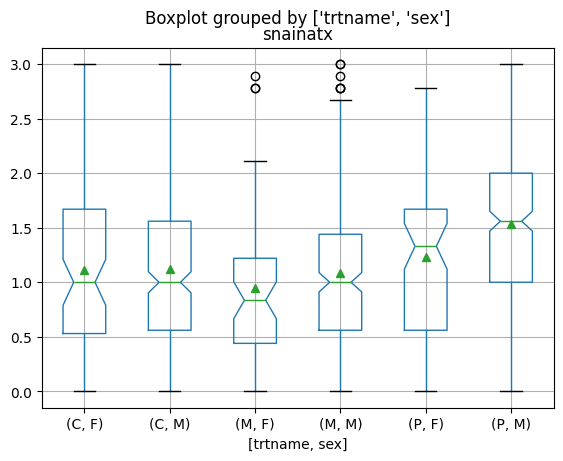

In [656]:
snap_14_p_t.boxplot(['snainatx'], by=['trtname', 'sex'], showmeans = True, notch=True)

In [605]:
rp.summary_cont(snap_p_t_treat.groupby('trtname')['snainatx'])

,N,Mean,SD,SE,95% Conf.,Interval
trtname,,,,,,
C,1862,1.5049,0.8209,0.0190,1.4676,1.5422
M,1575,1.5220,0.8576,0.0216,1.4797,1.5644
P,1951,1.6856,0.8067,0.0183,1.6498,1.7215


<Axes: title={'center': 'snahypax'}, xlabel='[trtname, sex]'>

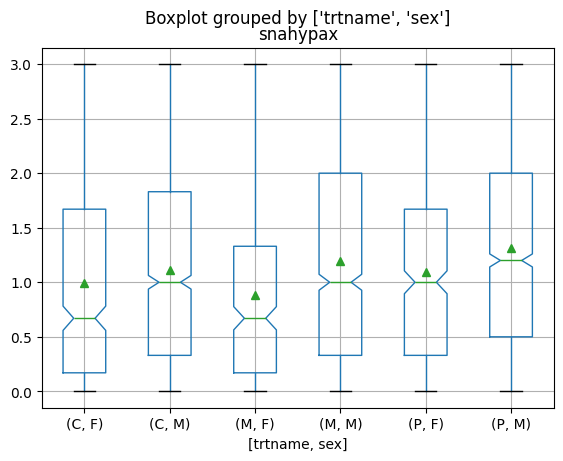

In [606]:
snap_p_t_treat.boxplot(['snahypax'], by=['trtname', 'sex'], showmeans = True, notch=True)

<Axes: title={'center': 'snaimpux'}, xlabel='[trtname, sex]'>

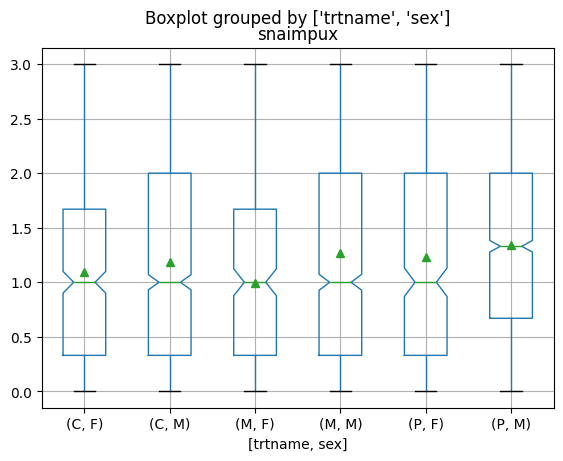

In [607]:
snap_p_t_treat.boxplot(['snaimpux'], by=['trtname', 'sex'], showmeans = True, notch=True)

<Axes: title={'center': 'snaoddx'}, xlabel='[trtname, sex]'>

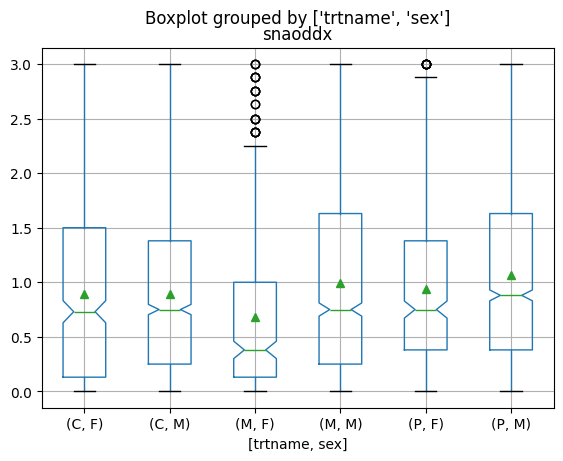

In [608]:
snap_p_t_treat.boxplot(['snaoddx'], by=['trtname', 'sex'], showmeans = True, notch=True)

In [616]:
snap_p_t_treat[['src_subject_id', 'days_baseline']]

,src_subject_id,days_baseline
0,P1434,3568
1,P1435,-206
2,P1435,116
3,P1435,189
4,P1435,399
...,...,...
5472,P1842,1277
5473,P1842,2418
5474,P1842,2422
5475,P1842,2924


In [698]:
snap_p_t.keys()

Index(['src_subject_id', 'interview_date', 'interview_age', 'sex', 'site',
       'days_baseline', 'relationship', 'snainatx', 'snainatt', 'snahypax',
       'snahypat', 'snaimpux', 'snaimput', 'snaoddx', 'snaoddt', 'p_t_bool',
       'log_days_baseline'],
      dtype='object')

### Fit model 


In [810]:
alpha = 0.05
group = 'src_subject_id'

def get_summary(result):
    summary_df = pd.DataFrame({
    'Coef.': result.params,
    'Std.Err.': result.bse,
    'z': result.tvalues,
    'P>|z|': result.pvalues,
    '0.025': result.conf_int()[0],
    '0.975': result.conf_int()[1]
})
    return summary_df

In [811]:
def get_RR_stats(formula, data):
    result = smf.mixedlm(formula, data, groups = data['src_subject_id']).fit()
    summary_df = get_summary(result)
    highlighted_summary = summary_df.style.apply(
    lambda x: ['background-color: blue' if v < alpha else '' for v in x], 
    subset=['P>|z|'])
    return highlighted_summary

In [812]:
snap_parent_mask = snap_14_p_t['p_t_bool'] == 1
data_p = snap_14_p_t[snap_parent_mask]

snap_teacher_mask = snap_14_p_t['p_t_bool'] == 2
data_t = snap_14_p_t[snap_teacher_mask]

## SNAP inattention

In [825]:
formula_inatt = 'snainatx ~ sex +  C(trtname, Treatment(reference = None)) * days_baseline * site' # reapeat with log days 

#### rater : Parent 

In [826]:
get_RR_stats(formula_inatt, data_p)

,Coef.,Std.Err.,z,P>|z|,0.025,0.975
Intercept,0.535093,0.635016,0.842645,0.399427,-0.709516,1.779702
sex[T.M],0.066495,0.110762,0.600343,0.548278,-0.150595,0.283586
"C(trtname, Treatment(reference=None))[T.M]",-0.095986,0.954665,-0.100544,0.919912,-1.967095,1.775123
"C(trtname, Treatment(reference=None))[T.P]",0.720648,0.815964,0.883186,0.377136,-0.878612,2.319907
days_baseline,0.001672,0.001676,0.997230,0.318653,-0.001614,0.004957
"C(trtname, Treatment(reference=None))[T.M]:days_baseline",0.000383,0.002529,0.151551,0.879541,-0.004574,0.005341
"C(trtname, Treatment(reference=None))[T.P]:days_baseline",-0.000114,0.002202,-0.051755,0.958724,-0.004431,0.004203
site,0.195955,0.137744,1.422606,0.154850,-0.074018,0.465927
"C(trtname, Treatment(reference=None))[T.M]:site",-0.134062,0.202772,-0.661148,0.508517,-0.531487,0.263363
"C(trtname, Treatment(reference=None))[T.P]:site",-0.109408,0.184509,-0.592968,0.553203,-0.471040,0.252223


In [827]:
get_RR_stats(formula_inatt, data_t)

,Coef.,Std.Err.,z,P>|z|,0.025,0.975
Intercept,0.962911,0.467213,2.060968,0.039306,0.047190,1.878631
sex[T.M],0.183551,0.092487,1.984617,0.047187,0.002280,0.364822
"C(trtname, Treatment(reference=None))[T.M]",0.044194,0.647584,0.068244,0.945591,-1.225047,1.313434
"C(trtname, Treatment(reference=None))[T.P]",0.650770,0.640515,1.016010,0.309625,-0.604617,1.906156
days_baseline,0.000050,0.001224,0.040631,0.967590,-0.002350,0.002449
"C(trtname, Treatment(reference=None))[T.M]:days_baseline",0.000416,0.001740,0.239319,0.810858,-0.002994,0.003827
"C(trtname, Treatment(reference=None))[T.P]:days_baseline",0.000231,0.001699,0.136013,0.891811,-0.003098,0.003560
site,0.022800,0.107264,0.212556,0.831673,-0.187434,0.233033
"C(trtname, Treatment(reference=None))[T.M]:site",0.019269,0.152028,0.126744,0.899143,-0.278701,0.317238
"C(trtname, Treatment(reference=None))[T.P]:site",0.022263,0.150875,0.147561,0.882690,-0.273447,0.317973


## SNAP Hyperactivity

In [833]:
formula_hyp = 'snahypax ~ sex +  C(trtname) * days_baseline * site' # reapeat with log days 


In [834]:
get_RR_stats(formula_hyp, data_p)

,Coef.,Std.Err.,z,P>|z|,0.025,0.975
Intercept,0.827579,0.628404,1.316955,0.187854,-0.404069,2.059227
sex[T.M],0.001956,0.118907,0.016450,0.986876,-0.231097,0.235009
C(trtname)[T.M],-0.092441,0.947137,-0.097601,0.922249,-1.948795,1.763913
C(trtname)[T.P],-0.054725,0.806785,-0.067831,0.945920,-1.635995,1.526545
days_baseline,-0.000285,0.001640,-0.173828,0.862000,-0.003500,0.002930
C(trtname)[T.M]:days_baseline,0.001106,0.002483,0.445364,0.656056,-0.003760,0.005972
C(trtname)[T.P]:days_baseline,0.002543,0.002158,1.178753,0.238496,-0.001686,0.006772
site,0.114164,0.136016,0.839342,0.401278,-0.152423,0.380751
C(trtname)[T.M]:site,-0.131554,0.201209,-0.653816,0.513230,-0.525915,0.262808
C(trtname)[T.P]:site,0.062258,0.182323,0.341469,0.732751,-0.295089,0.419604


In [835]:
get_RR_stats(formula_hyp, data_t)

,Coef.,Std.Err.,z,P>|z|,0.025,0.975
Intercept,0.953459,0.423779,2.249897,0.024456,0.122867,1.784051
sex[T.M],0.140396,0.083787,1.675628,0.093811,-0.023824,0.304617
C(trtname)[T.M],-0.487752,0.587881,-0.829679,0.406721,-1.639978,0.664473
C(trtname)[T.P],0.086933,0.580770,0.149685,0.881013,-1.051356,1.225222
days_baseline,-0.000748,0.001111,-0.673797,0.500440,-0.002925,0.001428
C(trtname)[T.M]:days_baseline,0.001870,0.001579,1.183967,0.236426,-0.001226,0.004965
C(trtname)[T.P]:days_baseline,0.001706,0.001540,1.108442,0.267671,-0.001311,0.004724
site,-0.021244,0.097245,-0.218457,0.827073,-0.211840,0.169352
C(trtname)[T.M]:site,0.088587,0.137904,0.642383,0.520624,-0.181699,0.358873
C(trtname)[T.P]:site,0.048206,0.136787,0.352418,0.724525,-0.219892,0.316305


## SNAP ODD 

In [836]:
formula_odd = 'snaoddx ~ sex +  C(trtname) * days_baseline * site' # reapeat with log days 

In [837]:
get_RR_stats(formula_odd, data_p)

,Coef.,Std.Err.,z,P>|z|,0.025,0.975
Intercept,1.334120,0.562518,2.371692,0.017707,0.231605,2.436634
sex[T.M],0.030828,0.125154,0.246321,0.805434,-0.214469,0.276125
C(trtname)[T.M],-0.076391,0.845348,-0.090366,0.927996,-1.733242,1.580460
C(trtname)[T.P],-1.223524,0.720386,-1.698428,0.089427,-2.635455,0.188407
days_baseline,-0.002057,0.001429,-1.439167,0.150103,-0.004859,0.000744
C(trtname)[T.M]:days_baseline,0.002085,0.002153,0.968175,0.332957,-0.002136,0.006305
C(trtname)[T.P]:days_baseline,0.005451,0.001884,2.893825,0.003806,0.001759,0.009143
site,-0.062852,0.121263,-0.518308,0.604244,-0.300524,0.174820
C(trtname)[T.M]:site,-0.076205,0.179930,-0.423526,0.671912,-0.428863,0.276452
C(trtname)[T.P]:site,0.201489,0.162862,1.237176,0.216022,-0.117715,0.520692


In [838]:
get_RR_stats(formula_odd, data_t)

,Coef.,Std.Err.,z,P>|z|,0.025,0.975
Intercept,0.712169,0.426253,1.670768,0.094768,-0.123271,1.547609
sex[T.M],-0.097235,0.089569,-1.085591,0.277660,-0.272787,0.078317
C(trtname)[T.M],-0.129004,0.590670,-0.218404,0.827115,-1.286697,1.028688
C(trtname)[T.P],0.741477,0.585362,1.266699,0.205263,-0.405811,1.888764
days_baseline,-0.000153,0.001107,-0.138477,0.889863,-0.002322,0.002016
C(trtname)[T.M]:days_baseline,0.001037,0.001574,0.658698,0.510090,-0.002048,0.004122
C(trtname)[T.P]:days_baseline,0.000025,0.001540,0.016055,0.987190,-0.002993,0.003043
site,0.029026,0.097774,0.296867,0.766568,-0.162608,0.220660
C(trtname)[T.M]:site,0.035585,0.138631,0.256687,0.797421,-0.236128,0.307297
C(trtname)[T.P]:site,-0.077575,0.137817,-0.562884,0.573514,-0.347692,0.192542
